In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [59]:
def binning_data(data_source, col_name, binned_col_name, num_of_bin=10, option="IQR"):
    """
    指定された列を指定されたbinの数に分割し、bin毎にラベル付けされたデータを元データに追加する
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    binned_col_name : string 
    num_of_bin : int
    
    return
    --------------
    data_source : pandas dataframe
    
    """
    
    if option == "IQR":
        #bin幅の決定のため四分位数を調べる。（外れ値を除く）
        data_info = data_source.describe()
        bin_min = data_info.loc["25%", col_name]
        bin_max = data_info.loc["75%", col_name]
        IQR = bin_max - bin_min
        bin_min = bin_min-IQR*1.5 if bin_min > IQR*1.5 else 0 #これ以下は外れ値とする。(0を最低値とする)
        bin_max += IQR*1.5 #これ以上は外れ値とする
    elif option == "MINMAX":
        data_info = data_source.describe()
        bin_min = data_info.loc["min", col_name]
        bin_max = data_info.loc["max", col_name]    
    
    bin_width = (int)((bin_max - bin_min) / num_of_bin)
    bins = [value for value in range((int)(bin_min), (int)(bin_max), bin_width )]
    #bin_width = (bin_max - bin_min) / num_of_bin
    #bins = [value for value in gen_range(bin_min, bin_max, bin_width )]
    labels = [i for i in range(0, len(bins)-1)]
    binned_label = pd.cut(data_source[col_name], bins=bins, labels=labels)
    data_source[binned_col_name] = binned_label

    for i in range(0, len(bins)-1):
        print("range label={} : range={:.5f}~{:.5f}".format(i, bins[i], bins[i+1]) )
    
    return data_source

### 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

### パイプライン関数

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target.reshape(-1), result[:,0], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return fpr, tpr, thresholds

### 試しにirisデータで計算してみる  
期待通り動いていそう。

In [3]:
from sklearn.datasets import load_iris
iris_data_set = load_iris()
x = pd.DataFrame(iris_data_set.data, columns=iris_data_set.feature_names)    #Put explanatory variable into x as pandasdata frame
y = pd.DataFrame(iris_data_set.target, columns=['Species'])    #Put iris response variable into y as pandasdata frame
df = pd.concat([x, y], axis=1)
data = df[df["Species"] != 0]

元データ数：100　学習データ数：75　検証データ数：25


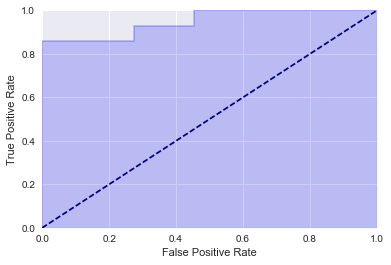

FPR=[0.         0.         0.         0.         0.18181818 0.27272727
 0.45454545 0.45454545 0.63636364 1.        ]
TPR=[0.         0.42857143 0.57142857 0.85714286 0.85714286 0.92857143
 0.92857143 1.         1.         1.        ]
Thresholds=[2.   1.   0.99 0.83 0.77 0.59 0.16 0.03 0.01 0.  ]


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=10)
#clf = KNeighborsClassifier(n_neighbors=3)

fpr, tpr, thresholds = pipline(clf, data, "Species", data.columns[[0,2]], 1, False)

print("FPR={}".format(fpr))
print("TPR={}".format(tpr))
print("Thresholds={}".format(thresholds))

### 実際に計算

特徴量を選ぶ(とりあえず前回のEDAの結果)  
1.OCCUPATION_TYPE  
2.ORGANIZATION_TYPE  
5.DAYS_EMPLOYED  
6.DAYS_REGISTRATION  
7.AMT_CREDIT  
8.DAYS_BIRTH  
9.DEF_60_CNT_SOCIAL_CIRCLE  
10.AMT_INCOME_TOTAL  
11.CNT_CHILDREN  

In [5]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [6]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [7]:
pd_reducted_train_data = pd_application_train[col_name]

In [8]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


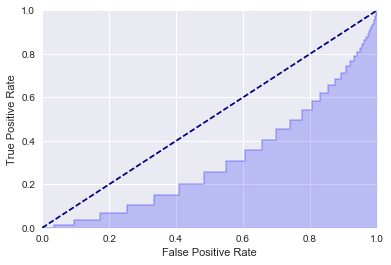

AUC=0.32846


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#clf = KNeighborsClassifier(n_neighbors=5)
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
fpr, tpr, thresholds = pipline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

モデルのパラメータ調整も必要かも。

### 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）
このAUCを計算する関数を作成してください。

In [10]:
def cal_auc(fpr, tpr):
    
    dx = fpr[1:]-fpr[:-1]     #X軸（fpr）について配列の隣同士の間隔を計算
    dy = (tpr[1:]+tpr[:-1])/2 #Y軸(tpr)について配列の右隣との平均値を計算
    integral = dx*dy
    """
    integral_under = dx * tpr[0:len(tpr)-1]
    integral_over = dx * tpr[1:len(tpr)]
    auc = (integral_under.sum()+integral_over.sum())/2
    """
    return integral.sum()

#### AUCを計算 (Sklearn Metric.aucの計算結果と比較)

In [11]:
print("AUC(with cal_auc)={:.6f}".format(cal_auc(fpr, tpr)))
print("AUC(with metrics.auc)={:.6f}".format(metrics.auc(fpr, tpr)))

AUC(with cal_auc)=0.329070
AUC(with metrics.auc)=0.329070


### 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。
汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

#### アプローチ ：データセットに新たな特徴量を加えてみる
個人で負債を抱える人の特徴としては、  
・複数ローンをしている  
・自己管理ができない、時間にルーズなど”いい加減” 
という特徴があるようだ。(ただし日本国内での調査結果に基づく)。
このことは、Week3 Seesion1で行なったEDAの結果、顧客の収入の他にその人物の特徴も重要な要素であるという推測と一致する。そこで、Home creditから与えれているデータを組み合わせ”いい加減”という特徴を数値化し新しい特徴量とすることを試みる。  
また、負債を抱えてしまった理由としては、  
・収入が少ない&急な収入の減少  
が上位に挙げられていた。しかしWeek3 Seesion1で行なったEDAの結果、単純に収入にだけでは未返済率にはっきりとした傾向は現れていなかった。そこで、新たなアプローチとして収入と必要な出費から"経済的な余裕の無さ"を数値化し新しい特徴量とすることを試みる。必要な出費の多さの指標として”子供の多さ”を用いる。

| ”無計画” & ”いい加減” の定義　| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入低いのに多く借りている |　AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICE | 得点化 |
| Nanの欄が多い | Nan | サンプル毎のNanの合計値の分布を適当なレンジに分ける。 |

| ”経済的な余裕のなさ”の定義| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入が低く子供が多い　　　|　　　AMT_INCOME_TOTAL, CNT_CHILDREN　　　 | 　得点化 （収入=低い&子供多い=>大 　収入=高い&子供少い=>大）|

AMT_INCOME_TOTAL、 CNT_CHILDREN、AMT_CREDIT、 AMT_GOODS_PRICE、 Nanの分布を見てみる。

In [22]:
col_name = ["TARGET", "AMT_INCOME_TOTAL", "CNT_CHILDREN", "AMT_CREDIT", "AMT_GOODS_PRICE"]
pd_data = pd_application_train[col_name]
pd_data.head()

,TARGET,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
0,1,202500.0,0,406597.5,351000.0
1,0,270000.0,0,1293502.5,1129500.0
2,0,67500.0,0,135000.0,135000.0
3,0,135000.0,0,312682.5,297000.0
4,0,121500.0,0,513000.0,513000.0


In [15]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 4 columns):
AMT_INCOME_TOTAL    307511 non-null float64
CNT_CHILDREN        307511 non-null int64
AMT_CREDIT          307511 non-null float64
AMT_GOODS_PRICE     307233 non-null float64
dtypes: float64(3), int64(1)
memory usage: 9.4 MB


In [17]:
pd_data.describe()

,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
count,3.075110e+05,307511.000000,3.075110e+05,3.072330e+05
mean,1.687979e+05,0.417052,5.990260e+05,5.383962e+05
std,2.371231e+05,0.722121,4.024908e+05,3.694465e+05
min,2.565000e+04,0.000000,4.500000e+04,4.050000e+04
25%,1.125000e+05,0.000000,2.700000e+05,2.385000e+05
50%,1.471500e+05,0.000000,5.135310e+05,4.500000e+05
75%,2.025000e+05,1.000000,8.086500e+05,6.795000e+05
max,1.170000e+08,19.000000,4.050000e+06,4.050000e+06


#### 1."収入低いのに多く借りている"について、AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICEから数値化

income
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
AMT_CREDIT


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~202078.00000
range label=1 : range=202078.00000~404156.00000
range label=2 : range=404156.00000~606234.00000
range label=3 : range=606234.00000~808312.00000
range label=4 : range=808312.00000~1010390.00000
range label=5 : range=1010390.00000~1212468.00000
range label=6 : range=1212468.00000~1414546.00000
range label=7 : range=1414546.00000~1616624.00000
AMT_GOODS_PRICE
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000


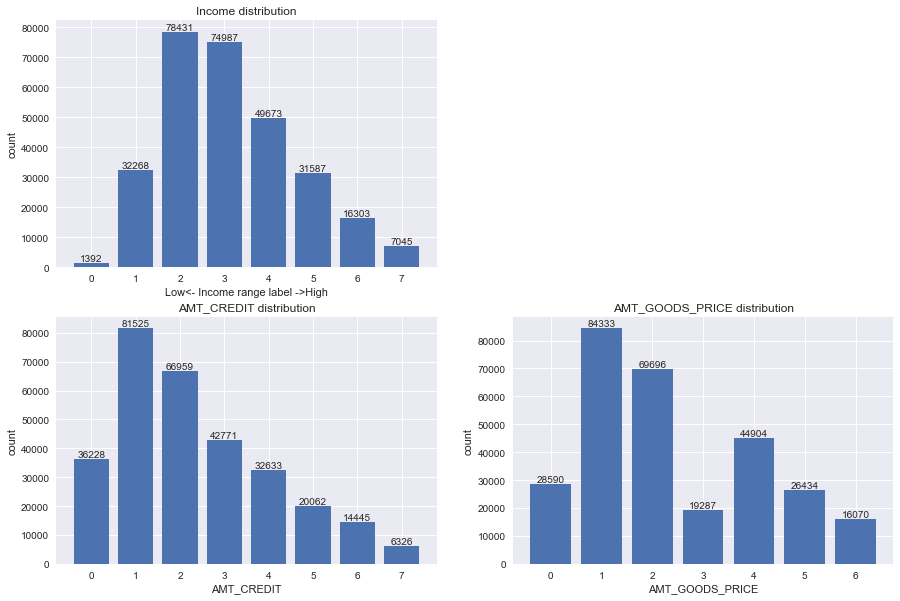

In [65]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('AMT_CREDIT distribution')
ax2.set_xlabel('AMT_CREDIT')
ax2.set_ylabel('count')
#plt.xlim([-1,15])
#plt.yscale("log")
ax2.grid(True)

ax3.set_title('AMT_GOODS_PRICE distribution')
ax3.set_xlabel('AMT_GOODS_PRICE')
ax3.set_ylabel('count')
#plt.xlim([-1,15])
#cale("log")
ax3.grid(True)

#Income
print("income")
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#AMT_CREDIT
print("AMT_CREDIT")
tmp = binning_data(pd_data, "AMT_CREDIT", "BIN_AMT_CREDIT", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_CREDIT", as_index=False).count()
ax2.bar(income_destribution_w_income_range["BIN_AMT_CREDIT"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_CREDIT"]
                , income_destribution_w_income_range["TARGET"]):
    ax2.text(x, y, y, ha='center', va='bottom')

#AMT_GOODS_PRICE
print("AMT_GOODS_PRICE")
tmp = binning_data(pd_data, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_GOODS_PRICE", as_index=False).count()
ax3.bar(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
                , income_destribution_w_income_range["TARGET"]):
    ax3.text(x, y, y, ha='center', va='bottom')
    
plt.show()

３つの特徴量は数値の高い方向に外れ値を持っており、この値はレンジ分けする際に範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。  

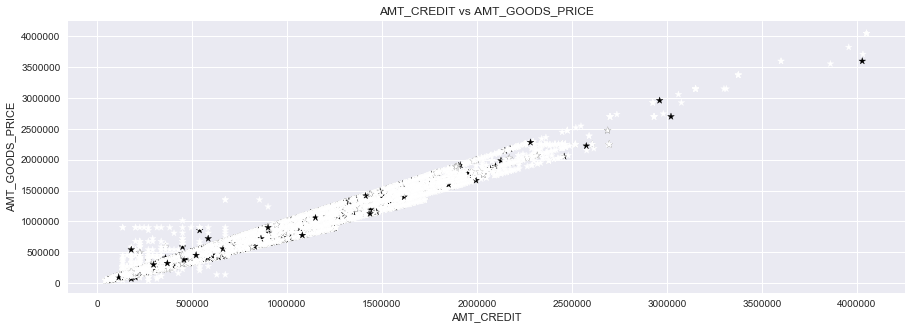

In [90]:
plt.figure(figsize=(15,5))
plt.title('AMT_CREDIT vs AMT_GOODS_PRICE')
plt.xlabel('AMT_CREDIT')
plt.ylabel('AMT_GOODS_PRICE')
plt.scatter(pd_data["AMT_CREDIT"], pd_data["AMT_GOODS_PRICE"], s=50, c=pd_data["TARGET"], marker='*')
plt.show()

In [91]:
x = pd_data["AMT_CREDIT"]
y = pd_data["AMT_GOODS_PRICE"]
x = x.replace(np.nan, -1)
y = y.replace(np.nan, -1)
np.corrcoef(x, y)

array([[1.       , 0.9866873],
       [0.9866873, 1.       ]])

"AMT_CREDIT" と "AMT_GOODS_PRICE"の相関係数はほぼ１なので、新しい指標の算出にはどちらか一方を用いる。
ここでは"AMT_GOODS_PRICE"を用いる。

"収入低いのに多く借りている"について、新しい指標を次のように定義する。  (10 - INCOME_RANGE) $\times$ "GOODS_PRICE_RANGE"

#### 2."Nanの欄が多い"について

#### 3."”経済的な余裕のなさ”の数値化について

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000


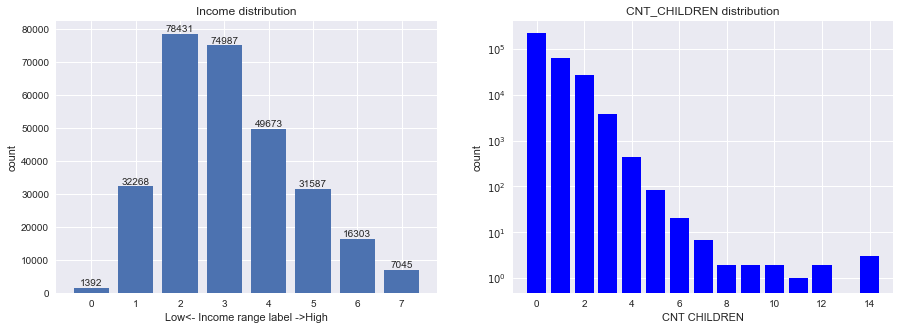

In [52]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))


ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('CNT_CHILDREN distribution')
ax2.set_xlabel('CNT CHILDREN')
ax2.set_ylabel('count')
plt.yscale("log")
plt.xlim([-1,15])
ax2.grid(True)

#Income
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#子供の数
cnt_children_destribution = tmp.groupby("CNT_CHILDREN", as_index=False).count()
ax2.bar(cnt_children_destribution["CNT_CHILDREN"], cnt_children_destribution["TARGET"], color="Blue")
    
#グラフ上に数値表示
"""
for x, y in zip(cnt_children_destribution.index, cnt_children_destribution["TARGET"]):
    ax2.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
"""
plt.show()

顧客の半分ほどは子供がいないことがわかった。利用者は未婚、若者が多い可能性がある。

"経済的な余裕のなさ"について、新しい指標として(10 - INCOME_RANGE) $\times$ CNT_CHILDRENを導入する。 
この値はその人物の経済的な負荷も表す。（収入が少なくて子供多い=>大 　収入が多くて子供少ない=>小）  
AMT_INCOME_TOTALには収入が高い方向に大きな外れ値が存在していて、この値はINCOME_RANGEでは範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。